<a href="https://colab.research.google.com/github/AnIsAsPe/Aprendizaje-no-supervisado/blob/main/Aprendizaje_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje no supervizado: Aplicaciones al clustering en Industiras

## 0. Cargar Bibliotecas

In [34]:
!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.2)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler  #estandarizar varibles
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from google.colab import files  #funcion para subir archivo csv a google colab

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Subir archivo de datos

In [36]:
#files.upload()

## Leer datos 

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/Aprendizaje-no-supervisado/main/Datos/train_input_2yaM34J.csv',
                    index_col=['ID'], parse_dates=['Date'])
df


,Date,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,,
0,2017-08-31 23:30:00,22.7,56.0,25.7,534.0,1.0
1,2017-09-01 00:30:00,22.8,55.0,25.7,506.0,1.0
2,2017-09-01 01:30:00,22.9,55.0,25.9,577.0,1.0
3,2017-09-01 02:30:00,23.0,55.0,26.1,630.0,1.0
4,2017-09-01 03:30:00,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...,...
7995,2018-02-18 17:30:00,20.5,26.0,18.4,390.0,5.0
7996,2018-02-18 18:00:00,20.4,26.0,18.3,383.0,2.0
7997,2018-02-18 18:30:00,20.3,26.0,18.2,377.0,1.0


# Exploración de datos

In [39]:
datos = df.copy()
datos.drop(['Date'],axis= 1, inplace=True)
datos.head(3)

,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,22.7,56.0,25.7,534.0,1.0
1,22.8,55.0,25.7,506.0,1.0
2,22.9,55.0,25.9,577.0,1.0


In [40]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  8000 non-null   float64
 1   Humidity     8000 non-null   float64
 2   Humex        8000 non-null   float64
 3   CO2          8000 non-null   float64
 4   Bright       8000 non-null   float64
dtypes: float64(5)
memory usage: 375.0 KB


## ¿Existen casos faltantes?




En caso afirmativo:
1. Remover renglones con valores faltantes

  `dropna()`
2. Imputar valores faltante con el promedio, la mediana o la moda de la columna.

  `fillna(df.columna.mean()`
3. Valor estimado mediante otro modelo de aprendizaje de máquina.

In [43]:
datos.isna().sum()

Temperature    0
Humidity       0
Humex          0
CO2            0
Bright         0
dtype: int64

In [49]:
datos.describe()

,Temperature,Humidity,Humex,CO2,Bright
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000
mean,22.94535,33.790750,22.668763,586.471000,41.596375
std,1.62307,8.241068,2.578996,202.641522,76.855898
min,17.90000,16.000000,15.500000,361.000000,1.000000
25%,22.10000,27.000000,21.100000,452.000000,1.000000
50%,23.20000,33.000000,22.800000,493.000000,1.000000
75%,24.10000,41.000000,24.300000,693.250000,58.000000
max,28.30000,58.000000,32.100000,2168.000000,882.000000


## Distribución y correlación entre variables

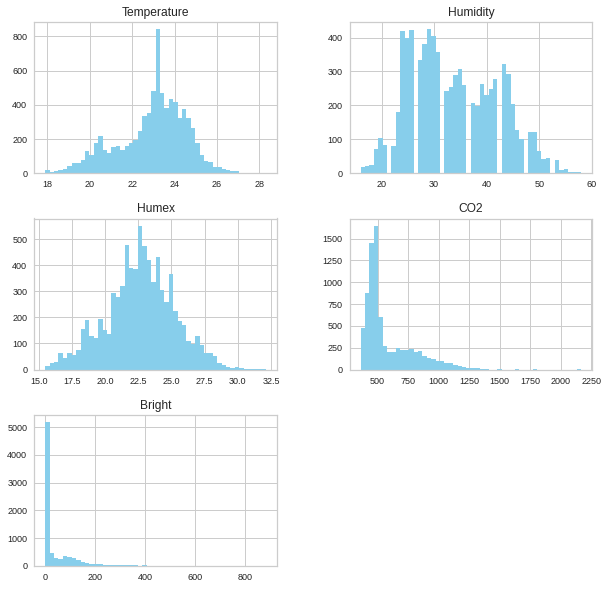

In [44]:
datos.hist(figsize = (10,10), xlabelsize=9, ylabelsize=9,
                               color='skyblue', bins=50)
plt.show()

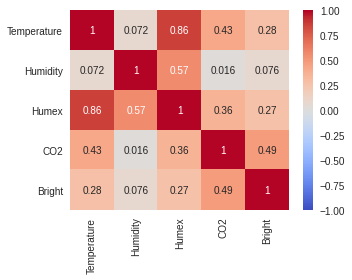

In [45]:
def correlacion(dataframe, grafica = True):
    corr=dataframe.corr()                #creamos la matriz de correlación
    fig = plt.figure(figsize = (5, 4))
    if grafica == True:
        sns.heatmap(corr,  cmap="coolwarm", 
                    vmin=-1, vmax=1,  center=0, 
                    annot=True, square=False)
        fig.tight_layout()
    return corr
correlaciones = correlacion(datos)

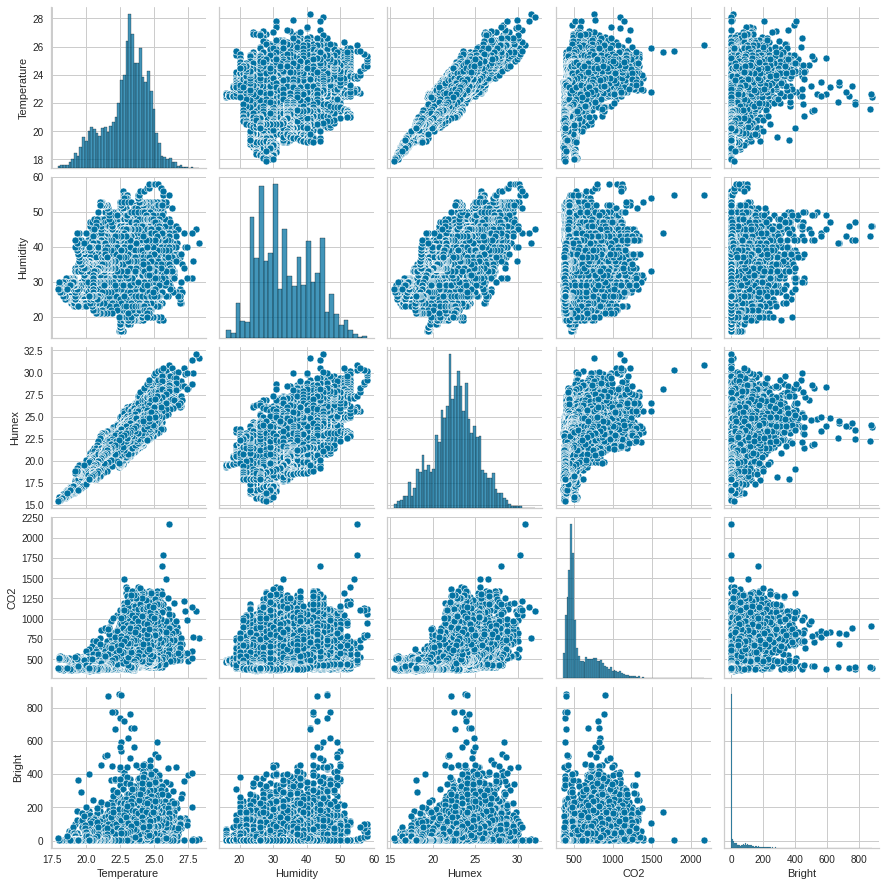

In [46]:
g = sns.pairplot(datos, palette ='Dark2')

plt.show()

## Unificar escalas de medición de cada variable

In [47]:
datos_escalados = datos.copy()
columnas = datos.columns

escala = MinMaxScaler()
#escala =StandardScaler()

datos_escalados[columnas] = escala.fit_transform(datos[columnas])
datos_escalados

,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,0.461538,0.952381,0.614458,0.095739,0.000000
1,0.471154,0.928571,0.614458,0.080243,0.000000
2,0.480769,0.928571,0.626506,0.119535,0.000000
3,0.490385,0.928571,0.638554,0.148866,0.000000
4,0.490385,0.928571,0.638554,0.156060,0.000000
...,...,...,...,...,...
7995,0.250000,0.238095,0.174699,0.016049,0.004540
7996,0.240385,0.238095,0.168675,0.012175,0.001135
7997,0.230769,0.238095,0.162651,0.008854,0.000000


In [48]:
datos_escalados.describe()

,Temperature,Humidity,Humex,CO2,Bright
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.485130,0.423589,0.431853,0.124776,0.046080
std,0.156064,0.196216,0.155361,0.112143,0.087237
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.403846,0.261905,0.337349,0.050360,0.000000
50%,0.509615,0.404762,0.439759,0.073049,0.000000
75%,0.596154,0.595238,0.530120,0.183868,0.064699
max,1.000000,1.000000,1.000000,1.000000,1.000000


# Selección del número de clústers 

### Elbow Method

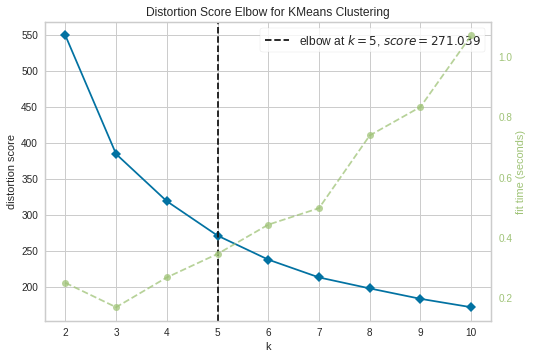

In [ ]:
codo = KElbowVisualizer(KMeans(random_state=3),   metric='distortion')
codo.fit(datos_escalados)
codo.poof()

### Coeficiente de Silhouette

El coeficiente de Silhouette evalúa la cercania entre puntos de un mismo cluster al mismo tiempo que la distancia a los clusters vecinos.
 
El coeficiente de Silhouette oscila entre -1 y 1 donde 1 indica un clúster de alta densidad y -1 que no existe densidad alguna.

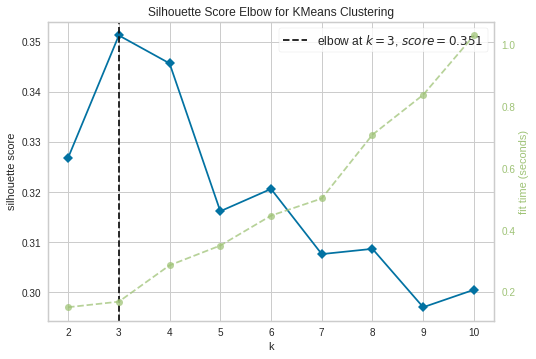

In [ ]:
codo = KElbowVisualizer(KMeans(random_state=3), metric='silhouette')
codo.fit(datos_escalados)
codo.poof()

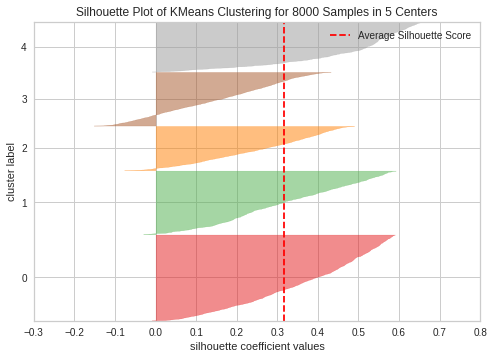

In [ ]:
model = KMeans(5, random_state=3)
graf_sil = SilhouetteVisualizer(model)
graf_sil.fit(datos_escalados)
graf_sil.poof()

# K means

In [ ]:
model = KMeans(n_clusters = 5, random_state=3).fit(datos_escalados)
clusters = model.predict(datos_escalados)

In [ ]:
datos.insert(0, 'cluster', clusters+1)
datos

,cluster,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,,
0,4,22.7,56.0,25.7,534.0,1.0
1,4,22.8,55.0,25.7,506.0,1.0
2,4,22.9,55.0,25.9,577.0,1.0
3,4,23.0,55.0,26.1,630.0,1.0
4,4,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...,...
7995,5,20.5,26.0,18.4,390.0,5.0
7996,5,20.4,26.0,18.3,383.0,2.0
7997,5,20.3,26.0,18.2,377.0,1.0


In [ ]:
datos.cluster.value_counts().sort_index()

1    2316
2    1714
3    1194
4    1446
5    1330
Name: cluster, dtype: int64

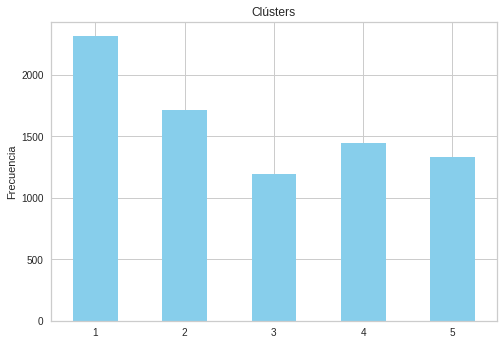

In [ ]:
g = datos.cluster.value_counts().sort_index().plot(kind='bar', 
                                                rot=0, 
                                                color='skyblue',
                                                )
g.set(ylabel='Frecuencia', title='Clústers')
plt.show()

In [ ]:
datos_escalados['cluster']= clusters+1


In [ ]:
datos_escalados.cluster = datos_escalados.cluster.astype(str)

In [ ]:
fig = px.scatter_3d(datos_escalados, x='Humidity', y='Bright', z='Humex',
                    color='cluster',
                    title="3D Scatter Plot", size='CO2')

fig.show()

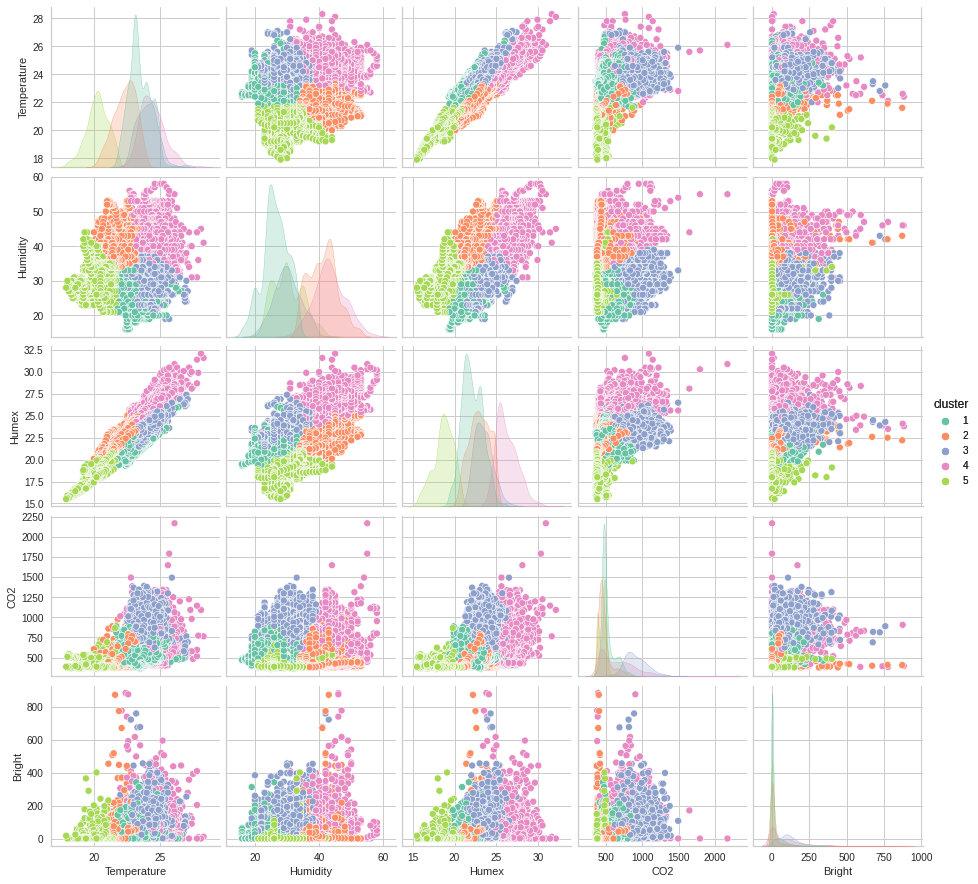

In [ ]:
mediciones = ['cluster', 'Temperature', 'Humidity', 'Humex', 'CO2', 'Bright']


g = sns.pairplot(datos[mediciones], hue='cluster', palette='Set2')
g.add_legend()
plt.show()